# Absolute vs Relative Time Index Demo

This notebook demonstrates the `AbsoluteRelativeIndex, which handles trial-based 
data where each trial has both absolute time (experiment time) and relative time
(time within the trial).

![Diagram of two possible abs-rel indexes](images/abs-rel.png.excalidraw.png)

In [1]:
from linked_indices import AbsoluteRelativeIndex
from linked_indices.example_data import trial_based_dataset

## Applying the AbsoluteRelativeIndex

Now we apply the `AbsoluteRelativeIndex` to link the absolute time, relative time, trial, and trial onset coordinates together. This enables selection by any of these coordinates.

In [2]:
# Generate example trial-based data
# 3 trials with distinct waveforms: cosine, square, sawtooth
# Each 5 seconds long, sampled at 100 Hz
ds = trial_based_dataset(mode="stacked")
ds = ds.drop_indexes(["trial", "rel_time"]).set_xindex(
    ["abs_time", "trial", "rel_time", "trial_onset"],
    AbsoluteRelativeIndex,
)
ds

<xarray.Dataset> Size: 28kB
Dimensions:      (trial: 3, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time     (trial, rel_time) float64 12kB 0.0 0.01 0.02 ... 14.98 14.99
  * trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial, rel_time) float64 12kB 1.0 0.9995 0.998 ... -0.02 -0.01
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

## Visualizing the Data

With the index applied, we can use xarray's plotting to visualize the data. The top plot shows the continuous absolute time, while the bottom shows each trial stacked by relative time.

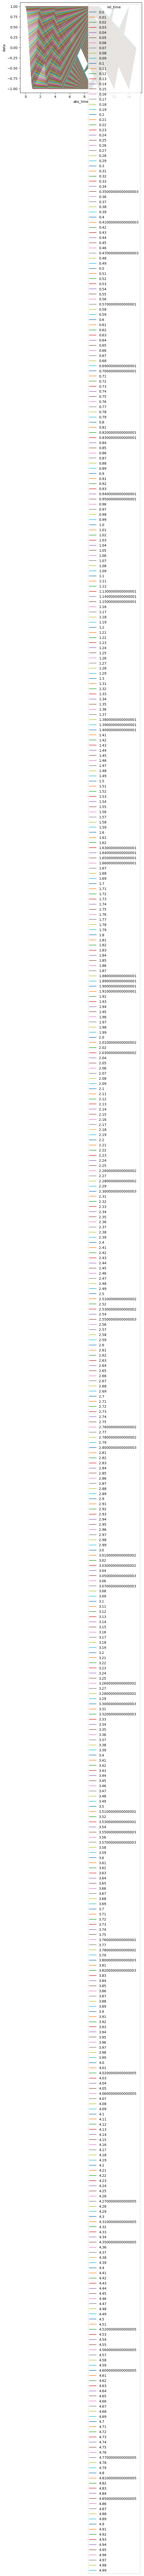

In [3]:
# Plot vs absolute time - continuous timeline
ds["data"].plot.line(x="abs_time")

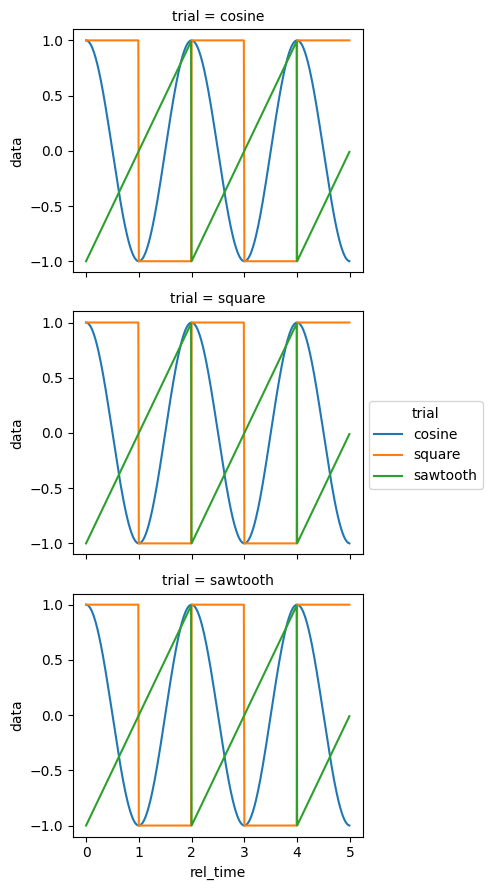

In [4]:
# Plot vs relative time - stacked by trial
ds["data"].plot.line(x="rel_time", row="trial")

## Selection Examples

### Select by absolute time

Selecting `abs_time=7.5` finds the point in the "square" trial (which spans 5-10s absolute time), at `rel_time=2.5`.

In [5]:
ds.sel(abs_time=7.5, method="nearest")

<xarray.Dataset> Size: 64B
Dimensions:      (trial: 1, rel_time: 1)
Coordinates:
  * trial        (trial) <U8 32B 'square'
  * rel_time     (rel_time) float64 8B 2.5
  * abs_time     (trial, rel_time) float64 8B 7.5
  * trial_onset  (trial) float64 8B 5.0
Data variables:
    data         (trial, rel_time) float64 8B 1.0
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

### Select a range of absolute time

Selecting `abs_time` from 2.5 to 7.5 spans the "cosine" trial (0-5s) and "square" trial (5-10s).

In [6]:
ds.sel(abs_time=slice(2.5, 7.5))

<xarray.Dataset> Size: 20kB
Dimensions:      (trial: 2, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 64B 'cosine' 'square'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time     (trial, rel_time) float64 8kB 0.0 0.01 0.02 ... 9.97 9.98 9.99
  * trial_onset  (trial) float64 16B 0.0 5.0
Data variables:
    data         (trial, rel_time) float64 8kB 1.0 0.9995 0.998 ... 1.0 1.0 1.0
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

### Select by trial

Selecting by trial name returns all data for that trial, with the corresponding absolute time range (5.0-10.0s for "square").

In [7]:
ds.sel(trial="square")

<xarray.Dataset> Size: 28kB
Dimensions:      (trial: 3, rel_time: 500)
Coordinates:
  * trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time     (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time     (trial, rel_time) float64 12kB 0.0 0.01 0.02 ... 14.98 14.99
  * trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial, rel_time) float64 12kB 1.0 0.9995 0.998 ... -0.02 -0.01
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

### Select by relative time

Selecting by relative time returns the same timepoint within each trial. This is useful for comparing equivalent moments across trials (e.g., 2.5 seconds after trial onset).

In [8]:
ds.sel(rel_time=2.5, method="nearest")

<xarray.Dataset> Size: 176B
Dimensions:      (trial: 3)
Coordinates:
    trial        (trial) <U8 96B 'cosine' 'square' 'sawtooth'
    abs_time     (trial) float64 24B 2.5 7.5 12.5
    rel_time     float64 8B 2.5
    trial_onset  (trial) float64 24B 0.0 5.0 10.0
Data variables:
    data         (trial) float64 24B 3.062e-16 1.0 -0.5

## Time-Locking to Events

You could accomplish most of the above with standard xarray index objects, but the real power comes from when we can add a new relative coordinate that has a different reference point per trial. This comes up, for example, when time-locking to speech onset in an EEG recording.

![Diagram of time-locking](images/event-locking.png.excalidraw.png)

Let's add a `speech_onset` coordinate that varies per trial, then create a `speech_locked_time` coordinate that measures time relative to that event.

In [9]:
# Add speech onset times that vary per trial
ds = ds.assign_coords({"speech_onset": ("trial", [1.5, 2.5, 3.0])})
ds

<xarray.Dataset> Size: 28kB
Dimensions:       (trial: 3, rel_time: 500)
Coordinates:
  * trial         (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time      (rel_time) float64 4kB 0.0 0.01 0.02 0.03 ... 4.97 4.98 4.99
  * abs_time      (trial, rel_time) float64 12kB 0.0 0.01 0.02 ... 14.98 14.99
  * trial_onset   (trial) float64 24B 0.0 5.0 10.0
    speech_onset  (trial) float64 24B 1.5 2.5 3.0
Data variables:
    data          (trial, rel_time) float64 12kB 1.0 0.9995 ... -0.02 -0.01
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

Now we create a `speech_locked_time` coordinate by subtracting `speech_onset` from `rel_time`. This gives us a time axis where 0 corresponds to speech onset for each trial.

In [16]:
# Create speech-locked time: time relative to speech onset
ds = ds.assign_coords({"speech_locked_time": ds["rel_time"] - ds["speech_onset"]})
ds

<xarray.Dataset> Size: 40kB
Dimensions:             (trial: 3, rel_time: 500)
Coordinates:
  * trial               (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time            (rel_time) float64 4kB 0.0 0.01 0.02 ... 4.97 4.98 4.99
  * abs_time            (trial, rel_time) float64 12kB 0.0 0.01 ... 14.98 14.99
  * trial_onset         (trial) float64 24B 0.0 5.0 10.0
    speech_onset        (trial) float64 24B 1.5 2.5 3.0
    speech_locked_time  (rel_time, trial) float64 12kB -1.5 -2.5 ... 2.49 1.99
Data variables:
    data                (trial, rel_time) float64 12kB 1.0 0.9995 ... -0.01
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

Now we can plot the data aligned to speech onset. Notice how the waveforms are now aligned such that time=0 corresponds to the speech onset for each trial.

In [13]:
ds["data"]

<xarray.DataArray 'data' (trial: 3, rel_time: 500)> Size: 12kB
array([[ 1.        ,  0.99950656,  0.99802673, ..., -0.99556196,
        -0.99802673, -0.99950656],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-1.        , -0.99      , -0.98      , ..., -0.03      ,
        -0.02      , -0.01      ]], shape=(3, 500))
Coordinates:
  * trial               (trial) <U8 96B 'cosine' 'square' 'sawtooth'
  * rel_time            (rel_time) float64 4kB 0.0 0.01 0.02 ... 4.97 4.98 4.99
  * abs_time            (trial, rel_time) float64 12kB 0.0 0.01 ... 14.98 14.99
  * trial_onset         (trial) float64 24B 0.0 5.0 10.0
    speech_onset        (trial) float64 24B 1.5 2.5 3.0
    speech_locked_time  (rel_time, trial) float64 12kB -1.5 -2.5 ... 2.49 1.99
Indexes:
  ┌ abs_time     AbsoluteRelativeIndex
  │ trial
  │ rel_time
  └ trial_onset

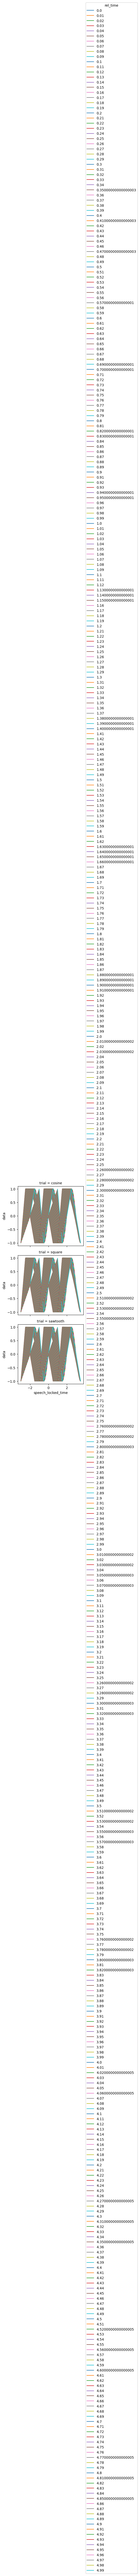

In [18]:
# Plot data aligned to speech onset
data = ds["data"]
data.plot.line(x="speech_locked_time", row="trial")